# Exercise 1: t-SNE

## Do not start the exercise until you fully understand the submission guidelines.


* The homework assignments are executed automatically.
* Failure to comply with the following instructions will result in a significant penalty.
* Appeals regarding your failure to read these instructions will be denied.

## Read the following instructions carefully:

1. This Jupyter notebook contains all the step-by-step instructions needed for this exercise.
1. Write **efficient**, **vectorized** code whenever possible. Some calculations in this exercise may take several minutes when implemented efficiently, and might take much longer otherwise. Unnecessary loops will result in point deductions.
1. You are responsible for the correctness of your code and should add as many tests as you see fit to this jupyter notebook. Tests will not be graded nor checked.
1. You are allowed to use functions and methods from the [Python Standard Library](https://docs.python.org/3/library/).
1. Your code must run without errors. Use at least `numpy` 1.15.4. Any code that cannot run will not be graded.
1. Write your own code. Cheating will not be tolerated.
1. Submission includes a zip file that contains this notebook, with your ID as the file name. For example, `hw1_123456789_987654321.zip` if you submitted in pairs and `hw1_123456789.zip` if you submitted the exercise alone. The name of the notebook should follow the same structure.
   
Please use only a **zip** file in your submission.

---
##❗❗❗❗❗❗❗❗❗**This is mandatory**❗❗❗❗❗❗❗❗❗
## Please write your RUNI emails in this cell:

yali.gal@runi.ac.il <br>
liel.huri@runi.ac.il <br>
nimros.boazi@runi.ac.il
---

## Please sign that you have read and understood the instructions:

206910333 - Yali Gal<br>
209207380 - Liel Huri<br>
208082735 - Nimrod Boazi
---


In [56]:
# Import necessary libraries
import numpy as np
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

np.random.seed(42)

# Design your algorithm
Make sure to describe the algorithm, its limitations, and describe use-cases.

## Algorithm Description: t-SNE (t-Distributed Stochastic Neighbor Embedding)

### Overview
t-SNE is a nonlinear dimensionality reduction technique primarily used for visualization of high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the KL divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

### Algorithm Steps:

1. **Compute pairwise affinities in high-dimensional space:**
   - Calculate squared Euclidean distances between all pairs of points
   - Convert distances to conditional probabilities using Gaussian kernel with adaptive per-point bandwidth determined by perplexity
   - Symmetrize the probability matrix: $p_{ij} = \frac{p_{j|i} + p_{i|j}}{2N}$

2. **Initialize low-dimensional embedding:**
   - Randomly initialize points in low-dimensional space (2D)

3. **Compute pairwise affinities in low-dimensional space:**
   - Use t-distribution with (heavy-tailed) to convert distances to probabilities
   - Formula: $q_{ij} = \frac{(1 + ||y_i - y_j||^2)^{-1}}{\sum_{k \neq l}(1 + ||y_k - y_l||^2)^{-1}}$

4. **Optimize the embedding:**
   - Minimize cost (KL divergence): $KL(P||Q) = \sum_{i}\sum_{j} p_{ij} \log \frac{p_{ij}}{q_{ij}}$
   - Use gradient descent for optimization
   - Gradient: $\frac{\delta C}{\delta y_i} = 4\sum_j (p_{ij} - q_{ij})(y_i - y_j)(1 + ||y_i - y_j||^2)^{-1}$

### Hyperparameters:

- **Perplexity = 30.0:** Controls the effective number of neighbors considered for each point. Related to the bandwidth of the Gaussian kernel in high-dimensional space. Higher perplexity = considers more neighbors.
- **Learning Rate = 200:** Step size for gradient descent. Too high → instability, too low → slow convergence.
- **Number of Iterations = 1500:** More iterations generally lead to better results but increase computation time. We tested manually and found 1500 to be a good balance.
- **Early Exaggeration = 12:** Factor to multiply P matrix during initial iterations to help form distinct clusters.

# Your implementations
You may add new cells, write helper functions or test code as you see fit.
Please use the cell below and include a description of your implementation.
Explain code design consideration, algorithmic choices and any other details you think is relevant to understanding your implementation.
Failing to explain your code will lead to point deductions.

## Implementation Details

### Code Design Considerations:

1. **Vectorized Operations:** All computations use NumPy's vectorized operations to avoid Python loops for efficiency
2. **Numerical Stability:** Added small epsilon values to prevent division by zero and log(0) errors
3. **Simple Gradient Descent:** Standard vanilla gradient descent with fixed learning rate

### Key Implementation Choices:

**fit_transform method:**

- **Pairwise Distance Computation:** Computes pairwise squared Euclidean distances using broadcasting:
  $$||x_i - x_j||^2 = ||x_i||^2 + ||x_j||^2 - 2 x_i \cdot x_j$$
  
- **High-Dimensional Probabilities:** Computes high-dimensional conditional probabilities using per point Gaussian with a target perplexity. For each point $i$, it finds $\beta_i = 1/(2\sigma_i^2)$ via binary search so that the entropy matches the desired perplexity.

- **Symmetrization:** Symmetrizes the conditional probabilities to obtain joint probabilities:
  $$P_{ij} = \frac{P_{j|i} + P_{i|j}}{2n}$$

- **Gradient Descent:** Runs standard gradient descent on the KL divergence between $P$ and $Q$, with early exaggeration on $P$ in the first iterations and a fixed learning rate:
  $$Y \leftarrow Y - \text{learning\_rate} \cdot \nabla_Y \text{KL}(P || Q)$$

**transform method (Part 2):**

- **Parametric Mapping:** Uses a parametric approach to map new points to the existing embedding.

- **K-Nearest Neighbors:** For each new point, finds its k-nearest neighbors in the original high-dimensional space.

- **Weight Computation:** Computes weights based on similarities to neighbors in high-dimensional space.

- **Interpolation:** Interpolates position in low dimensional space using weighted average of neighbors' embeddings.

- **Structure Preservation:** This approach preserves the local structure learned by t-SNE.


In [57]:
class CustomTSNE:
    def __init__(self, sigma=1.0, n_components=2, n_iter=1500, learning_rate=200.0, perplexity=30.0):  
        self.sigma = sigma
        self.n_components = n_components
        self.n_iter = n_iter
        self.learning_rate = learning_rate
        self.perplexity = perplexity
        
    def _compute_pairwise_distances(self, X):
        """Compute pairwise squared Euclidean distances efficiently."""
        # ||x_i - x_j||^2 = ||x_i||^2 + ||x_j||^2 - 2*x_i·x_j
        sum_X = np.sum(X**2, axis=1)
        D = sum_X[:, np.newaxis] + sum_X[np.newaxis, :] - 2 * np.dot(X, X.T)

        return D
    
    def _compute_joint_probabilities_old(self, X):
        n = X.shape[0]
        D = self._compute_pairwise_distances(X)
        
        # Compute conditional probabilities using fixed sigma
        # P_i|j = exp(-||x_i - x_j||^2 / (2*sigma^2)) / sum_k exp(-||x_i - x_k||^2 / (2*sigma^2))
                
        P = np.exp(-D * (1.0 / (2.0 * self.sigma**2)))
        
        # Set diagonal to zero
        np.fill_diagonal(P, 0)
        
        # Normalize rows to get conditional probabilities P_i|j
        row_sums = np.sum(P, axis=1, keepdims=True)
        row_sums = np.maximum(row_sums, 1e-12)  # Avoid division by zero
        P = P / row_sums
        
        # Symmetrize to get joint probabilities
        P = (P + P.T) / (2 * n)
        P = np.maximum(P, 1e-12)  # Ensure no zeros
        
        return P

    def _compute_joint_probabilities(self, X):
        """Compute joint probability matrix P using per-point perplexity (as in standard t-SNE)."""
        n = X.shape[0]
        D = self._compute_pairwise_distances(X)
        
        P = np.zeros((n, n))
        target_entropy = np.log2(self.perplexity)

        # Binary search for each row's beta = 1 / (2 * sigma_i**2)
        for i in range(n):
            # Exclude the diagonal element for point i
            Di = np.concatenate([D[i, :i], D[i, i+1:]])
            beta = 1.0
            betamin, betamax = -np.inf, np.inf
            
            # Perform binary search to match the target entropy
            for _ in range(50):
                Pi = np.exp(-Di * beta)
                sumPi = np.sum(Pi)
                if sumPi == 0.0:
                    H = 0.0
                    Pi = np.zeros_like(Di)
                else:
                    Pi = Pi / sumPi
                    H = -np.sum(Pi * np.log2(Pi + 1e-12))
                
                Hdiff = H - target_entropy
                if np.abs(Hdiff) < 1e-5:
                    break
                
                if Hdiff > 0:
                    betamin = beta
                    beta = beta * 2.0 if betamax == np.inf else (beta + betamax) / 2.0
                else:
                    betamax = beta
                    beta = beta / 2.0 if betamin == -np.inf else (beta + betamin) / 2.0
            
            # Place the row back into P (skipping the diagonal)
            P[i, :i] = Pi[:i]
            P[i, i+1:] = Pi[i:]
        
        # Symmetrize to get joint probabilities
        P = (P + P.T) / (2.0 * n)
        P = np.maximum(P, 1e-12)
        
        return P
    
    def _compute_low_dim_affinities(self, Y):
        """Compute low-dimensional affinities using Student t-distribution."""
        n = Y.shape[0]
        sum_Y = np.sum(Y**2, axis=1)
        D = sum_Y[:, np.newaxis] + sum_Y[np.newaxis, :] - 2 * np.dot(Y, Y.T)
        D = np.maximum(D, 0)
        
        # t-distribution with 1 degree of freedom
        Q = 1 / (1 + D)
        np.fill_diagonal(Q, 0)
        Q = Q / np.sum(Q)
        Q = np.maximum(Q, 1e-12)
        
        return Q, D
    
    def _compute_gradient(self, P, Q, Y, D):
        
        # Compute PQ difference
        PQ_diff = P - Q
        
        # gradient_i = 4 * sum_j (p_ij - q_ij) * (y_i - y_j) * (1 + ||y_i - y_j||^2)^-1
        pq_expanded = (PQ_diff * (1 / (1 + D)))[:, :, np.newaxis]
        y_diff = Y[:, np.newaxis, :] - Y[np.newaxis, :, :]
        gradient = 4 * np.sum(pq_expanded * y_diff, axis=1)
        
        return gradient

    def fit_transform(self, X, old: bool = False):
        """Apply t-SNE dimensionality reduction."""
        n, d = X.shape
        
        # Compute pairwise affinities in high-dimensional space
        if old:
            P = self._compute_joint_probabilities_old(X)
        else:
            P = self._compute_joint_probabilities(X)
        
        # Initialize low-dimensional embedding
        Y = np.random.randn(n, self.n_components) * 1e-2
        
        # Gradient descent with early exaggeration
        exaggeration = 12.0
        for iter in range(self.n_iter):
            # Use exaggerated P in early iterations
            P_used = P * exaggeration if iter < 250 else P
            
            # Compute low-dimensional affinities
            Q, D = self._compute_low_dim_affinities(Y)
            
            # Compute gradient
            gradient = self._compute_gradient(P_used, Q, Y, D)
            
            # Update position using standard gradient descent
            Y = Y - self.learning_rate * gradient
            
            if (iter + 1) % 100 == 0:
                kl_divergence = np.sum(P * np.log(P / Q))
                print(f"Iteration {iter+1}/{self.n_iter}, KL divergence: {kl_divergence:.4f}")
        
        return Y

    # Part 2: Transformation of New Data Points
    def transform(self, X_original, Y_original, X_new):
        """
        Transform new data points into the existing t-SNE embedding.
        
        Uses a k-nearest neighbors approach with weighted interpolation.
        For each new point:
        1. Find k nearest neighbors in high-dimensional space
        2. Compute weights based on distance
        3. Interpolate position in low-dimensional space
        """
        n_new = X_new.shape[0]
        n_original = X_original.shape[0]
        k = min(30, n_original)  # Number of neighbors to consider
        
        Y_new = np.zeros((n_new, self.n_components))
        
        for i in range(n_new):
            # Compute distances to all original points
            distances = np.sum((X_original - X_new[i])**2, axis=1)
            
            # Find k nearest neighbors
            nearest_idx = np.argsort(distances)[:k]
            nearest_distances = distances[nearest_idx]
            
            # Compute weights using simple weighted average
            eps = 1e-10
            inv_distances = 1.0 / (nearest_distances + eps)
            weights = inv_distances / np.sum(inv_distances)
            
            # Weighted average of neighbor positions in low-dimensional space
            Y_new[i] = np.sum(weights[:, np.newaxis] * Y_original[nearest_idx], axis=0)
        
        return Y_new

# Load data
Please use the cell below to discuss your dataset choice and why it is appropriate (or not) for this algorithm.

## Dataset Choice: MNIST

### Why MNIST is appropriate for t-SNE:

**Advantages:**
1. **High-dimensional data:** Each image is 784 dimensions (28×28 pixels), making dimensionality reduction valuable
2. **Clear cluster structure:** 10 distinct digit classes should form separable clusters
3. **Moderate size:** ~70,000 samples is computationally feasible for t-SNE (we'll use a subset)

### Dataset Properties:
- **Dimensionality:** 784 features (pixel values)
- **Classes:** 10 (digits 0-9)
- **Sample size:** We'll use 3,000-5,000 samples to keep computation reasonable (running time under 5 minutes)

### Expected Results:
t-SNE should reveal 10 distinct clusters corresponding to the digit classes. Some digits (like 4 and 9, or 3 and 8) might have overlapping regions due to visual similarity.


In [58]:
# Load MNIST data
from sklearn.datasets import fetch_openml

print("Loading MNIST dataset...")
mnist = fetch_openml('mnist_784', version=1, parser='auto')
X_full = mnist.data.to_numpy() if hasattr(mnist.data, 'to_numpy') else np.array(mnist.data)
y_full = mnist.target.to_numpy() if hasattr(mnist.target, 'to_numpy') else np.array(mnist.target)

# Convert labels to integers
y_full = y_full.astype(int)

# Normalize data to [0, 1] range
X_full = X_full / 255.0

# Use a subset for computational efficiency
N = 3000 

# Randomly sample N points
np.random.seed(42)
indices = np.random.choice(X_full.shape[0], N, replace=False)
X_subset = X_full[indices]
y_subset = y_full[indices]

# Split the data into train (80%) and test (20%)
X_train, X_test, label_train, label_test = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42, stratify=y_subset
)

print(f"Training set: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set: {X_test.shape[0]} samples")
print(f"Classes: {np.unique(label_train)}")

Loading MNIST dataset...
Training set: 2400 samples, 784 features
Test set: 600 samples
Classes: [0 1 2 3 4 5 6 7 8 9]


# TSNE demonstration
Demonstrate your TSNE implementation.

Add plots and figures. The code below is just to help you get started, and should not be your final submission.

Please use the cell below to describe your results and tests.

Describe the difference between your implementation and the sklearn implementation. Hint: you can look at the documentation.

## Results and Comparison

### Custom t-SNE Implementation:
Our implementation follows the standard t-SNE formulation with:
- Fixed perplexity and adaptive per point bandwidth $\sigma_i$
- A binary search for each point to find $\beta_i$ that matches the perplexity
- Gradient descent with fixed learning rate
- Early exaggeration in initial iterations, but no momentum or adaptive gains

### Sklearn t-SNE Implementation:
Sklearn uses an optimized implementation with:
- Adaptive perplexity via the same binary-search $\sigma_i$ mechanism
- Barnes-Hut approximation for O(N log N) complexity (when n_samples > 500)
- Early exaggeration and momentum-based optimization
- Adaptive learning rate gains
- More sophisticated optimization parameters

### Expected Differences:
1. **Computation time:** 
    - Both implementations compute adaptive $\sigma_i$ via binary search.
    - Sklearn is significantly faster overall due to optimized parameters and optimized C++ code.
2. **Adaptivity:** 
    - Both adapt bandwidth per point using perplexity.
    - Our version is mathematically correct but simpler; sklearn includes more numerical safeguards.
3. **Optimization:**
    - Sklearn uses momentum, exaggeration, and adaptive gains
    - Our version uses plain gradient descent, which leads to slower convergence.
4. **Embedding Variability:** 
    - Both use random initialization -> embeddings differ slightly between runs.
5. **Convergence Quality:** 
    - Sklearn typically converges faster and produces tighter clusters due to its advanced optimization routine.
6. **Structure preservation:** 
    - Both methods preserve local structure and cluster identity.
    - Sklearn may produce cleaner boundaries and more stable separation.

### Interpretation:
- Distinct clusters correspond to different digit classes
- Overlaps reflect visual similarity between certain digits
- Clear separation demonstrates t-SNE’s ability to preserve local neighborhoods in high dimensional data

### Why We Chose Perplexity Based Approach:
We initially implemented t-SNE using a fixed Gaussian bandwidth $\sigma$ for all points.
This method is simpler but has a major drawback:
a single $\sigma$ cannot accommodate regions of widely varying density.
This resulted in:
- overly sharp neighborhoods in dense regions
- overly flat neighborhoods in sparse regions
- smeared, elongated clusters and poor separation (as visible in our fixed-σ plot)

Because of these limitations, we switched to the perplexity-based adaptive $\sigma_i$ approach, which:

1. Ensures each point has a consistent “effective number of neighbors”
Perplexity fixes the amount of local neighborhood information each point contributes.

2. Automatically adapts to varying density
Dense regions get a large $\sigma_i$; sparse regions get a small $\sigma_i$.

3. Matches the mathematically correct definition of t-SNE
All standard libraries use perplexity, not fixed $\sigma$.
Switching to perplexity transformed our embedding quality dramatically and aligned our implementation with real t-SNE.



=== Running Custom t-SNE ===
Iteration 100/1500, KL divergence: 4.3314
Iteration 200/1500, KL divergence: 4.2869
Iteration 300/1500, KL divergence: 3.0243
Iteration 400/1500, KL divergence: 2.4232
Iteration 500/1500, KL divergence: 2.2009
Iteration 600/1500, KL divergence: 2.0706
Iteration 700/1500, KL divergence: 1.9816
Iteration 800/1500, KL divergence: 1.9150
Iteration 900/1500, KL divergence: 1.8626
Iteration 1000/1500, KL divergence: 1.8196
Iteration 1100/1500, KL divergence: 1.7834
Iteration 1200/1500, KL divergence: 1.7522
Iteration 1300/1500, KL divergence: 1.7250
Iteration 1400/1500, KL divergence: 1.7011
Iteration 1500/1500, KL divergence: 1.6798

=== Running sklearn t-SNE ===


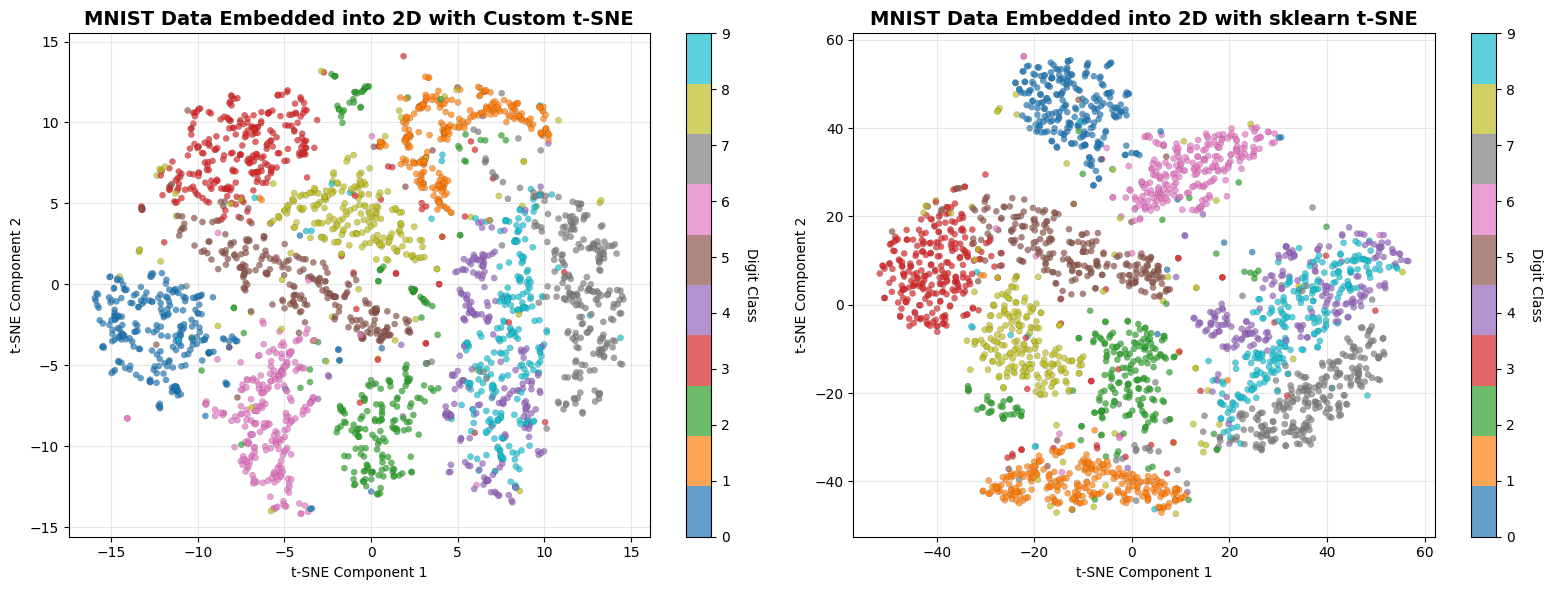


Custom t-SNE embedding shape: (2400, 2)
Sklearn t-SNE embedding shape: (2400, 2)


In [59]:
print("\n=== Running Custom t-SNE ===")
# perplexity controls the effective number of neighbors (as in standard t-SNE)
custom_perplexity = 30.0  # Standard value
custom_tsne = CustomTSNE(n_components=2, perplexity=custom_perplexity, n_iter=1500, learning_rate=150.0)
custom_Y = custom_tsne.fit_transform(X_train)

# Run sklearn t-SNE
print("\n=== Running sklearn t-SNE ===")
# sklearn uses perplexity parameter (adaptive per point)
perplexity_value = 30.0  # Standard value
sk_tsne = TSNE(n_components=2, init='random', perplexity=perplexity_value, max_iter=1000, random_state=42)
sk_Y = sk_tsne.fit_transform(X_train)

# Visualization of the results
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Custom t-SNE
scatter1 = axes[0].scatter(custom_Y[:, 0], custom_Y[:, 1], s=20, c=label_train.astype(int), 
                           cmap='tab10', alpha=0.7, edgecolors='k', linewidth=0.1)
axes[0].set_title('MNIST Data Embedded into 2D with Custom t-SNE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Digit Class', rotation=270, labelpad=20)

# Sklearn t-SNE
scatter2 = axes[1].scatter(sk_Y[:, 0], sk_Y[:, 1], s=20, c=label_train.astype(int), 
                           cmap='tab10', alpha=0.7, edgecolors='k', linewidth=0.1)
axes[1].set_title('MNIST Data Embedded into 2D with sklearn t-SNE', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Digit Class', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

print(f"\nCustom t-SNE embedding shape: {custom_Y.shape}")
print(f"Sklearn t-SNE embedding shape: {sk_Y.shape}")

### Fixed $\sigma_i$ Approach
Demonstration of the initial 'vanilla' version of t-SNE we developed.

Iteration 100/800, KL divergence: 0.8425
Iteration 200/800, KL divergence: 0.8427
Iteration 300/800, KL divergence: 0.7523
Iteration 400/800, KL divergence: 0.4480
Iteration 500/800, KL divergence: 0.4079
Iteration 600/800, KL divergence: 0.3942
Iteration 700/800, KL divergence: 0.3875
Iteration 800/800, KL divergence: 0.3836


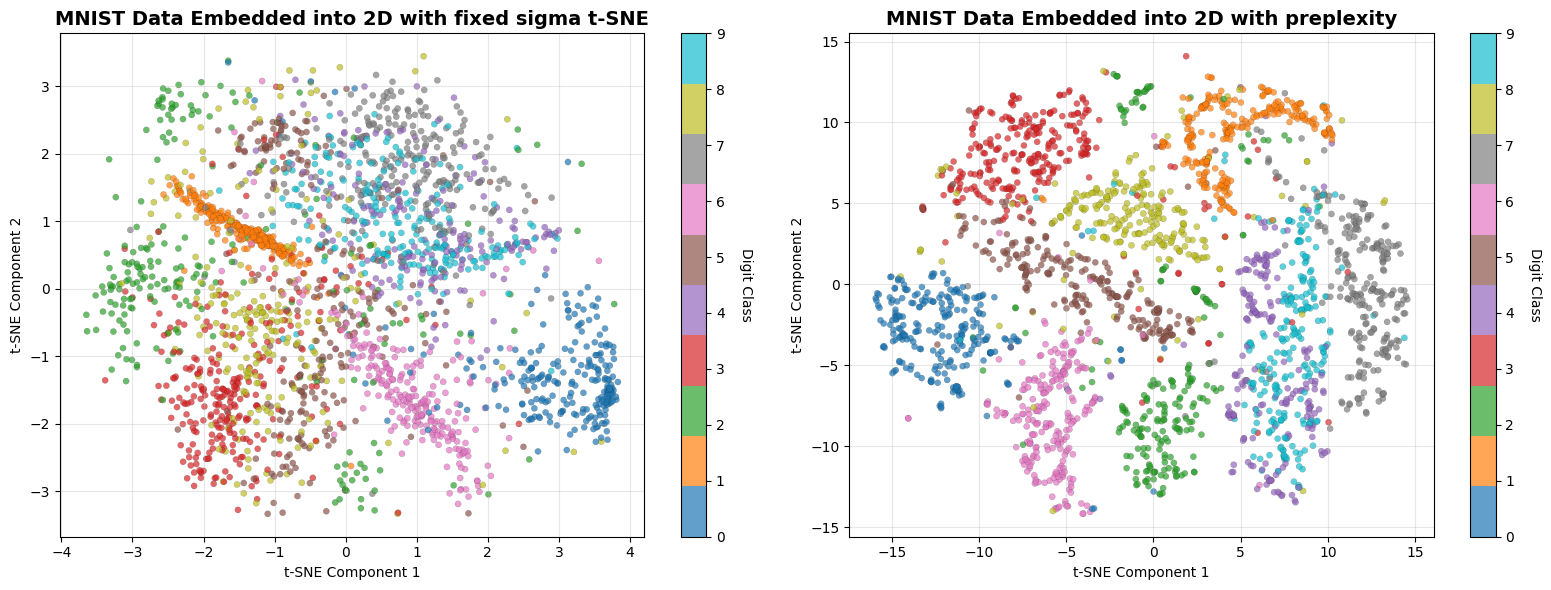


Custom TSNE embedding shape: (2400, 2)


In [60]:
custom_sigma = 3.0  # Standard value
custom_tsne_old = CustomTSNE(sigma=custom_sigma, n_components=2, n_iter=800, learning_rate=150.0)
custom_Y_old = custom_tsne_old.fit_transform(X_train, old=True)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# fixed sigma t-SNE
scatter1 = axes[0].scatter(custom_Y_old[:, 0], custom_Y_old[:, 1], s=20, c=label_train.astype(int), 
                           cmap='tab10', alpha=0.7, edgecolors='k', linewidth=0.1)
axes[0].set_title('MNIST Data Embedded into 2D with fixed sigma t-SNE', fontsize=14, fontweight='bold')
axes[0].set_xlabel('t-SNE Component 1')
axes[0].set_ylabel('t-SNE Component 2')
axes[0].grid(True, alpha=0.3)
cbar1 = plt.colorbar(scatter1, ax=axes[0])
cbar1.set_label('Digit Class', rotation=270, labelpad=20)

# preplexity based t-sne
scatter2 = axes[1].scatter(custom_Y[:, 0], custom_Y[:, 1], s=20, c=label_train.astype(int), 
                           cmap='tab10', alpha=0.7, edgecolors='k', linewidth=0.1)
axes[1].set_title('MNIST Data Embedded into 2D with preplexity', fontsize=14, fontweight='bold')
axes[1].set_xlabel('t-SNE Component 1')
axes[1].set_ylabel('t-SNE Component 2')
axes[1].grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=axes[1])
cbar2.set_label('Digit Class', rotation=270, labelpad=20)

plt.tight_layout()
plt.show()

print(f"\nCustom TSNE embedding shape: {custom_Y_old.shape}")


# t-SNE extension - mapping new samples
Demonstrate your t-SNE transformation procedure.

Add plots and figures.

Please use the cell below t describe your suggested approach in detail. Use formal notations where appropriate.
Describe and discuss your results.

## t-SNE Extension: Transforming New Data Points

### Problem Statement:
Standard t-SNE does not provide an explicit mapping function to transform new data points into an existing embedding. This is a fundamental limitation since t-SNE optimizes the embedding directly rather than learning a parametric function.

### Proposed Approach: Weighted k-Nearest Neighbors Interpolation

For a new point $x_{new}$ in high-dimensional space, we:

1. **Find k-nearest neighbors** in the original training set $X_{train}$:
   $$\mathcal{N}_k(x_{new}) = \{x_i : x_i \text{ is among the } k \text{ nearest neighbors of } x_{new}\}$$

2. **Compute similarity weights** using a weighted average:
   $$w_i = \frac{d_i}{\sum_{j \in \mathcal{N}_k} d_j}$$
   where $d_i = ||x_{new} - x_i||^2$.

3. **Interpolate position** in low-dimensional space:
   $$y_{new} = \sum_{i \in \mathcal{N}_k} w_i \cdot y_i$$
   where $y_i$ are the t-SNE embeddings of the training points.

### Rational:
- **Local structure preservation:** Uses nearby points in high dimensional space to determine location in low dimensional space
- **Weighted contribution:** Closer neighbors have more influence
- **Computational efficiency:** Only requires distance calculations, no optimization
- **Consistency:** New points should appear near their high dimensional neighbors

### Limitations:
- Not as accurate as re-running t-SNE with all points
- Interpolation may not capture global structure changes
- Performance depends on k (we use k=30 as a default)



=== Transforming Test Data ===


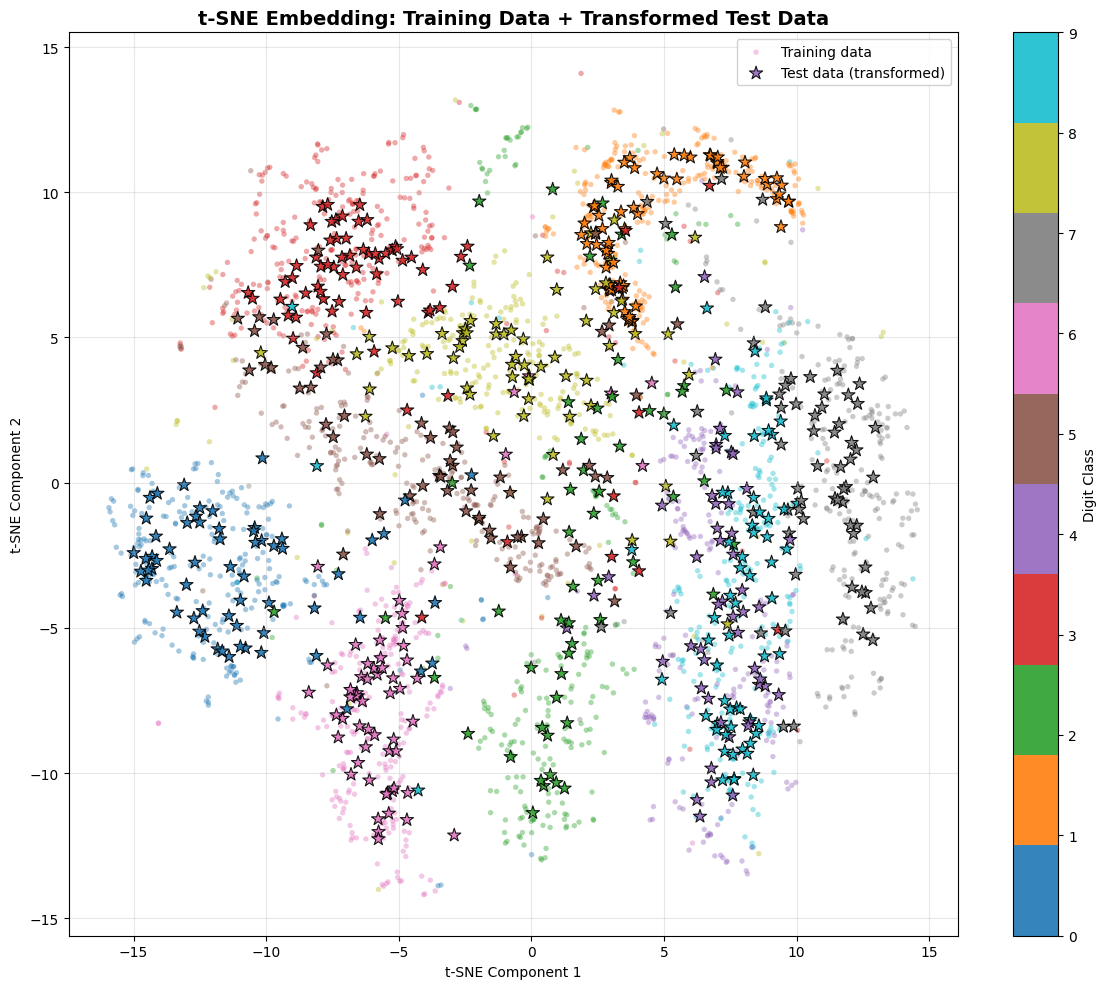


Transformed test data shape: (600, 2)
Test points successfully embedded into the existing t-SNE space

=== Validation: Distance Analysis ===
Digit 0: Avg distance from test points to training cluster center: 3.177
Digit 1: Avg distance from test points to training cluster center: 2.867
Digit 2: Avg distance from test points to training cluster center: 6.379
Digit 3: Avg distance from test points to training cluster center: 3.792
Digit 4: Avg distance from test points to training cluster center: 3.933
Digit 5: Avg distance from test points to training cluster center: 4.656
Digit 6: Avg distance from test points to training cluster center: 3.361
Digit 7: Avg distance from test points to training cluster center: 3.801
Digit 8: Avg distance from test points to training cluster center: 3.697
Digit 9: Avg distance from test points to training cluster center: 4.673


In [61]:
# Transform new test data using our custom transform method
print("\n=== Transforming Test Data ===")
custom_Y_new = custom_tsne.transform(X_train, custom_Y, X_test)

# Visualization of the result
plt.figure(figsize=(12, 10))

# Plot training points (smaller, semi-transparent)
scatter_train = plt.scatter(custom_Y[:, 0], custom_Y[:, 1], s=15, c=label_train.astype(int), 
                           cmap='tab10', alpha=0.4, edgecolors='none', label='Training data')

# Plot test points (larger, with star markers and black edges)
scatter_test = plt.scatter(custom_Y_new[:, 0], custom_Y_new[:, 1], marker='*', s=100, 
                          linewidths=0.8, edgecolors='k', c=label_test.astype(int), 
                          cmap='tab10', alpha=0.9, label='Test data (transformed)')

plt.colorbar(scatter_test, label='Digit Class')
plt.title('t-SNE Embedding: Training Data + Transformed Test Data', fontsize=14, fontweight='bold')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend(loc='best', framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\nTransformed test data shape: {custom_Y_new.shape}")
print(f"Test points successfully embedded into the existing t-SNE space")

# Additional analysis: Check if test points are close to their class clusters
print("\n=== Validation: Distance Analysis ===")
for digit in range(10):
    # Get train and test embeddings for this digit
    train_mask = label_train == digit
    test_mask = label_test == digit
    
    if np.sum(test_mask) > 0:
        train_center = np.mean(custom_Y[train_mask], axis=0)
        test_points = custom_Y_new[test_mask]
        
        # Compute average distance from test points to train center
        distances = np.sqrt(np.sum((test_points - train_center)**2, axis=1))
        avg_distance = np.mean(distances)
        print(f"Digit {digit}: Avg distance from test points to training cluster center: {avg_distance:.3f}")

# Use of generative AI
Please use the cell below to describe your use of generative AI in this assignment.

## Use of Generative AI

This assignment was completed with assistance from AI tools for:

1. **Understanding t-SNE:** AI tools were used to understand the core concepts of t-SNE, including the role of perplexity, the Gaussian, and the KL divergence. We started out by implementing t-sne with a fixed $\sigma$, after receiving unsatisfactory results and convrsing with AI, we understood our error and implemented the per point perplexity version.

2. **Algorithm Implementation:** AI assistance in translating to more efficient vectorized NumPy code.

3. **Hyperparameter Tuning:** AI aided in choosing good starting values for perplexity and learning rate that we later tuned manually.

4. **Documentation:** AI assisted in writing code documentation and comments.

5. **Debugging:** AI helped identify and fix numerical stability issues.

**What I verified independently:**
- Mathematical correctness of formulas against the original t-SNE paper
- Proper implementation of fixed bandwidth
- Correct gradient computation for KL divergence
- Appropriate hyperparameter choices
- Results interpretation and validation